In [2]:
import numpy as np
import pandas as pd

In [1]:
filename='datasets/galadriel_dataset_24_09_06_phys.h5'

In [3]:
df_input=pd.read_hdf(filename,'df_input')
df_camera=pd.read_hdf(filename,'df_camera')


#get the arrays and print them
print('Input DF')
print(df_input)

print('----')
print('Camera 1D')
print(df_camera)

Input DF
      shot number   order2   order3     order4  Laser Energy
0          129950  34900.0 -17000.0 -4600000.0      0.002349
1          129951  35300.0   4000.0 -4300000.0      0.002186
2          129952  35300.0   4000.0 -4300000.0      0.002333
3          129953  35300.0   4000.0 -4300000.0      0.002284
4          129954  35300.0   4000.0 -4300000.0      0.002234
...           ...      ...      ...        ...           ...
3060       133018  35100.0  10000.0 -3700000.0      0.002270
3061       133019  35100.0  10000.0 -3700000.0      0.002356
3062       133020  35100.0  10000.0 -3700000.0      0.002295
3063       133021  35100.0  10000.0 -3700000.0      0.002283
3064       133022  35100.0  10000.0 -3700000.0      0.002278

[3065 rows x 5 columns]
----
Camera 1D
           0          1          2          3          4          5     \
0      4.380935   6.480935   6.580935   4.200935   6.420935   6.420935   
1     20.815341  20.695341  21.935341  21.195341  25.155341  24.135341 

In [53]:
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

#get the shot number from the test index
def get_shot_num(shot_index,df_input):
    #id_value=y_test.iloc[shot_index].name
    return(df_input['shot number'].iloc[shot_index])

def rmv_mean(df_camera,lastpoints):
    x=np.linspace(0,len(df_camera.columns)-1,len(df_camera.columns))
    #get the coeficients for each shhot
    coef=df_camera.apply(lambda row: np.polyfit(x[-lastpoints:], row[-lastpoints:], 1),axis=1, result_type='expand').to_numpy()
    m=coef[:,0]
    b=coef[:,1]

    #build the aray with the fitting for every shot
    fit=[]
    for i in range(0,len(m)):
        fit.append(m[i]*x+b[i])
    df_fitting=pd.DataFrame(fit)

    #df_adjusted=df_camera-df_fitting
    return df_camera-df_fitting

def cam_analysis(df_camera,df_input,lastpoints,shot_ind=60):
    #check temperature(or other) effects on all dataset
    cam_sum=df_camera.sum(axis=1)/len(df_camera.columns)
    plt.plot(cam_sum)
    plt.xlabel('Shot index')
    plt.ylabel('Average count per pixel')
    plt.title('Temperature (or other effects) in all run')
    plt.show()

    #smooth and drop the last values
    df_camera_smooth=df_camera.apply(uniform_filter1d,axis=1,size=10,result_type='broadcast')
    df_camera_smooth=df_camera_smooth.iloc[:,0:2000].copy()

    #remove the average signal. Fit a line to the last values and substract it
    #lastpoints=300
    df_camera_adjusted=rmv_mean(df_camera_smooth,lastpoints)
    
    

    #############
    #plot the data from one shot
    #shot_ind=int(0.1*len(df_camera)) #some random shot
    shot_numb=get_shot_num(shot_ind,df_input)
    
    e_dist_original=df_camera.loc[shot_ind]  #original shot
    e_dist_smooth=df_camera_smooth.loc[shot_ind]  #smooth shot
    x=np.linspace(0,len(df_camera.columns)-1,len(df_camera.columns))
    x_smooth=np.linspace(0,len(df_camera_smooth.columns)-1,len(df_camera_smooth.columns))

    #tail fitting
    m,b = np.polyfit(x_smooth[-lastpoints:], e_dist_smooth[-lastpoints:], 1)
    x_fitting=np.linspace(len(df_camera_smooth.columns)-lastpoints,len(df_camera_smooth.columns),20)
    fitting=m*x_fitting+b
    #shot after removing tail fit
    e_dist_adj=df_camera_adjusted.loc[shot_ind]
    
    plt.plot(x,e_dist_original,label='Original')
    plt.plot(x_smooth,e_dist_smooth,label='After smoothing')
    plt.plot(x_fitting,fitting,label='Tail fit')
    plt.plot(x_smooth,e_dist_adj,label='After rmv tail fit')
    plt.xlabel('Pixels')
    plt.title('shot #'+str(shot_numb))
    plt.legend()
    plt.show()
    return df_camera_adjusted

In [76]:
#build the metrics
from scipy.optimize import curve_fit
from scipy import integrate

#####
def conv_energy(x):
    energy=0.000002*x**2 - 0.0003 * x + .1265
    return energy
######
## Fit a curve to given (x,y) data
def fitting(x,y,p0):
    popt, pcov = curve_fit(func, x, y,p0,maxfev=1000)
    return popt

#define the curve to fit
def func(t,c0, c1,c2): 
    #return c0*np.log(c1)+c2*t
    #return c0*x**2+c1*x+c2
    return c0*np.exp(-((t-c1)**2)/(2*c2*c2))

#Look for max location using the fitting function (around the maximum value)
#Returns the 'pixel' location of the maximum
def find_max(e_dist):
    try:
        #x=np.linspace(0,len(e_dist)-1,len(e_dist))
        #redefine a shorter range around the max
        e_zoom=e_dist[int(0.5*np.argmax(e_dist)):int(1.5*np.argmax(e_dist))]
        x_zoom=np.linspace(int(0.5*np.argmax(e_dist)),int(1.5*np.argmax(e_dist))-1,len(e_zoom))
        #p0=[np.max(e_dist),500,1]#initial guess
        p0=[np.max(e_dist),np.argmax(e_dist),1]#initial guess
        popt=fitting(x_zoom,e_zoom,p0)
    except:
        print('Error in the find max')
        popt=[0,0,0]
    if(popt[1]>len(e_dist) or popt[1]<0):
        return 0 #could'nt find the max with this method
    else:
        return popt[1]
        
#input a single shot (and the max location) and returns the position of the cut-off
def get_cutoff(df_camera_shot,maxpos):
    #The function look for the first zero value after the max value
    cutoff_poss=df_camera_shot[int(maxpos):][df_camera_shot<0].dropna().index[0]
    return cutoff_poss

#input a single shot and returns the position of the cut-off
#This will be SLOWER than the other approach
def get_cutoff_2(df_camera_shot):
    #The function look for the first zero value after the max value
    #1:Look for the max value
    maxpos=find_max(df_camera_shot)
    #print(maxpos,len(df_camera_shot))
    #2)
    cutoff_poss=df_camera_shot[int(maxpos):][df_camera_shot<0].dropna().index[0]
    return cutoff_poss

def integr(e_dist):
    x=np.linspace(0,len(e_dist)-1,len(e_dist))
    #calculate the start(first positive) and end of integration(cut off)
    max_pos=find_max(e_dist)
    cutoff_pos=get_cutoff(e_dist,max_pos)  #end position
    start_pos=0
    for i in range(0,len(e_dist)):
        if (e_dist[i]>0):
            #print(i,e_dist[i])
            start_pos=i
            break
    e_dist_short=e_dist[start_pos:cutoff_pos]
    x_short=x[start_pos:cutoff_pos]
    
    #x=np.linspace(0,len(e_dist_short)-1,len(e_dist_short))
    x_ene=conv_energy(x_short)
    #return integrate.simpson(e_dist, x=x_ene)
    return integrate.trapezoid(e_dist_short, x=x_ene)

##################################

def build_metrics(df_camera_adjusted,df_input,shot_ind=60):
    #CONSTRUCT THE METRICS dataframe
    
    #plot an example shot
    shot_numb=get_shot_num(shot_ind,df_input)
    x_adj=np.linspace(0,len(df_camera_adjusted.columns)-1,len(df_camera_adjusted.columns))
    e_dist_adj=df_camera_adjusted.loc[shot_ind]
    #the peak value
    maxpos=find_max(e_dist_adj)
    yaux=np.linspace(0,np.max(e_dist_adj),10)
    xaux_max=0*yaux+maxpos
    x_max_ene=conv_energy(xaux_max)
    #the cut-off position
    cutoff_pos=get_cutoff_2(e_dist_adj)
    xaux_cutoff=0*yaux+cutoff_pos
    x_cutoff_ene=conv_energy(xaux_cutoff)
    #integral
    auc=integr(e_dist_adj)
    
    
    plt.plot(conv_energy(x_adj),e_dist_adj,label='E dist')
    plt.plot(x_max_ene,yaux,label='Peak energy')
    plt.plot(x_cutoff_ene,yaux,label='Cutoff')
    plt.xlabel('E(MeV)')
    plt.title('shot #'+str(shot_numb)+'    Area under curve='+str(auc))
    plt.legend()
    plt.show()
    


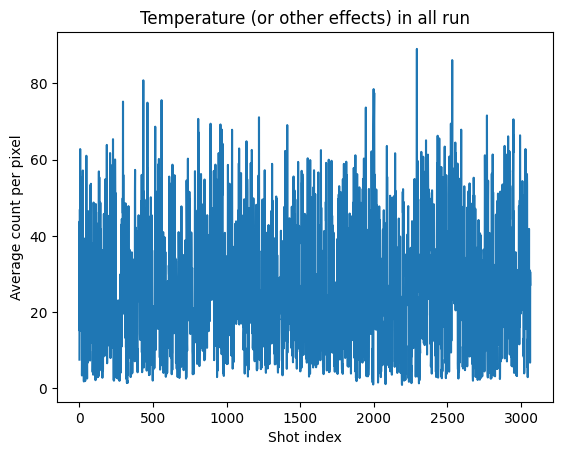

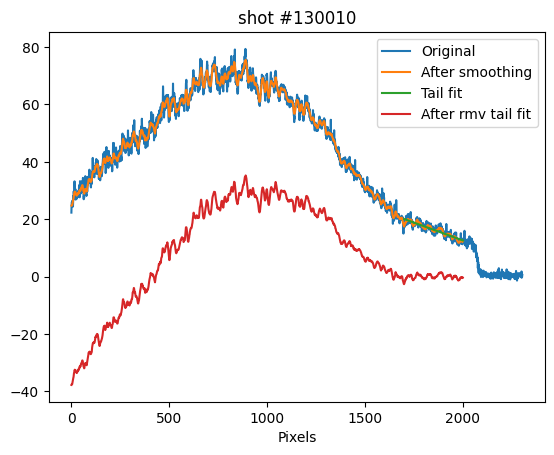

In [54]:
lastpoints=300 #fit a line to the last points and remove that trend from the shot data
df_camera_adjusted=cam_analysis(df_camera,df_input,lastpoints)

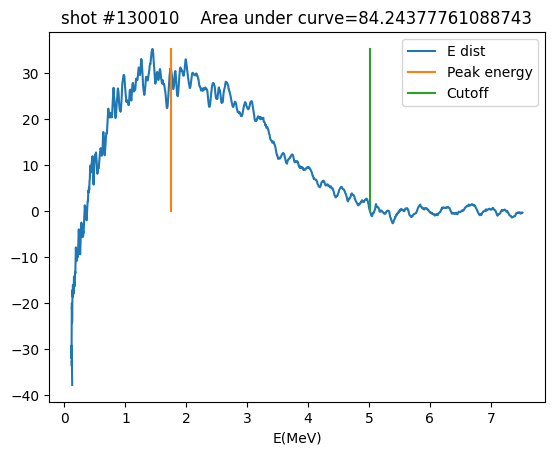

In [77]:
build_metrics(df_camera_adjusted,df_input)